In [2]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
#imported dependencies continued
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import linregress

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
Base.prepare(engine,reflect=True)
# reflect the tables


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#check coulmn names and types 
inspector=inspect(engine)
columns= inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
inspector=inspect(engine)
columns= inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

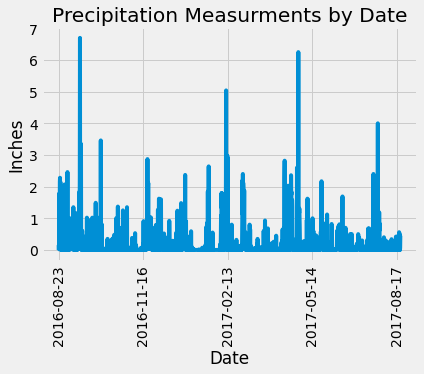

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
final_date=dt.date(2017,8,23)
starting_date=final_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

sel=[Measurement.date, func.sum(Measurement.prcp)]
prcp_data=session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= f'{starting_date}').\
    filter(Measurement.date <= f'{final_date}').\
    filter(Measurement.prcp != 'None').\
    order_by(Measurement.date).all()


#Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(prcp_data,columns=['date','prcp'])
prcp_df.set_index('date',inplace=True)
# Sort the dataframe by date
prcp_df.sort_index(inplace=True)



# Use Pandas Plotting with Matplotlib to plot the data
#create y_axis for yticks
y_axis=np.arange(0,8)
prcp_df.plot(rot=90,yticks=y_axis,legend=False)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Measurments by Date')
#save fig to output data
plt.savefig("output/Precipitation_Measurements.png")
plt.show()







In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats=prcp_df.describe()
summary_stats


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).distinct().count()

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
test_data=session.query(Measurement.station,func.count(Measurement.station)).\
    filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
test_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp=session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
min_temp=session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
avg_temp=session.query(func.round(func.avg(Measurement.tobs))).filter(Measurement.station=='USC00519281').all()
 

In [25]:
#display max_temp,min_temp,_avg_temp
print(max_temp,min_temp,avg_temp)

[(85.0,)] [(54.0,)] [(72.0,)]


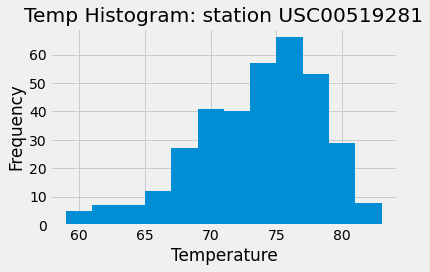

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_months=session.query(Measurement.tobs).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23'). all()
weather_list=[results[0] for results in twelve_months]
station_data=pd.DataFrame(twelve_months, columns=['Temperature'])
ax=station_data.plot.hist(legend=False,bins=12)
plt.xlabel('Temperature')
plt.title('Temp Histogram: station USC00519281')
plt.tight_layout()
#Save figure to output
plt.savefig("output/Temperature Histogram.png")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()